In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import pickle
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
import warnings
warnings.filterwarnings('ignore')
alt.renderers.enable('notebook')
py.init_notebook_mode(connected=True)
%matplotlib inline  

### Load Census and Net Income Madrid (City Hall) data

In [72]:
# Load census data from Madrid
census = pd.read_csv('./data/census_madrid_agg_segments.csv')

# Load net income data per districts in 2014
net_inc = pd.read_csv('./data/net_income_district_14.csv')

# Define high, medium and low class based on net income level:
# Upper class > 40K
# 40K > Middle class > 29k 
# 29k > Worker class
net_inc['social class'] = 'worker class'
net_inc.ix[net_inc[net_inc['net_income (euros)'] > 40000].index,'social class'] = 'upper class'
net_inc.ix[net_inc[(net_inc['net_income (euros)'] < 40000) & \
                   (net_inc['net_income (euros)'] > 29000)].index,'social class'] = 'middle class'
net_inc.to_csv('./data/net_income_classification_mad.csv', index=False, encoding='utf-8')

### Aggregate districts by net income level

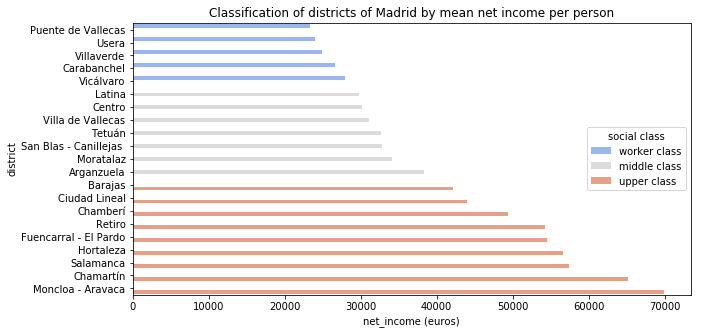

In [4]:
# Visualize social classes by net income in 2014
plt.figure(figsize=(10,5))
_ = sns.barplot(y='district',x='net_income (euros)',hue='social class',data=net_inc.sort_values(by='net_income (euros)'),
            palette=sns.color_palette("coolwarm", 3))
_ = plt.title("Classification of districts of Madrid by mean net income per person")
plt.savefig("social_class_District.png")

### Evaluate changes on population per social class per age range

In [65]:
def get_values_age_range(data, age_range, segment):
    a = data.loc[data['age_range']==age_range,\
              ('year',segment,'social class')]
    social_classes = []
    ratios = []
    for social_class, df in a.groupby('social class'):
        values = df[segment].tolist()
        social_classes.append(social_class)
        ratios.append(values)
        
    dataframe = pd.DataFrame(ratios).T
    dataframe['year'] = data.year.unique()
    dataframe = dataframe.set_index('year')
    dataframe.columns = social_classes
    return dataframe

def generate_data(data, df_classifier, age_ranges, segment):

    # Aggregation of values per social class
    # Assign social class to census data
    census_agg = data.merge(df_classifier, left_on=['district'], 
             right_on=['district']).ix[:,['district','year','age_range',segment,'social class']]
    census_agg = census_agg[census_agg['age_range'] != 'Total']
    census_agg = census_agg.groupby(['social class','year','age_range']).mean().reset_index()
    census_agg['label'] = census_agg['age_range'] + " " + census_agg['social class']

    age_range_dfs = []
    for age_range in age_ranges:
        age_range_dfs.append(get_values_age_range(census_agg, age_range, segment))
        
    return age_range_dfs

In [67]:
# Generate aggregated census data per age segment for visualizations
age_ranges = ['0-24','25-39','40-64','65-84','85-100']
segments = ['total','spanish_total','foreign_total']

age_range_dfs_total = generate_data(census, net_inc, age_ranges, segments[0])
age_range_dfs_spanish = generate_data(census, net_inc, age_ranges, segments[1])
age_range_dfs_foreign = generate_data(census, net_inc, age_ranges, segments[2])

In [71]:
# Pickle data for visualizations with plot.ly
file1 = open("./data/df_census_visualizations_total.pkl",'wb')
file2 = open("./data/df_census_visualizations_spanish.pkl",'wb')
file3 = open("./data/df_census_visualizations_foreign.pkl",'wb')
pickle.dump(age_range_dfs_total,file1)
pickle.dump(age_range_dfs_spanish,file2)
pickle.dump(age_range_dfs_foreign,file3)

### Visualize results

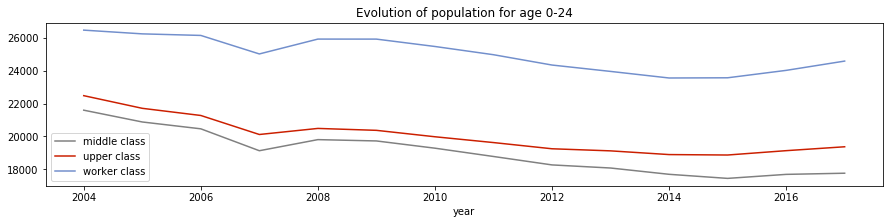

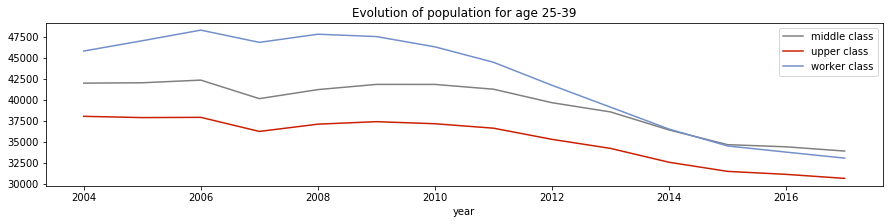

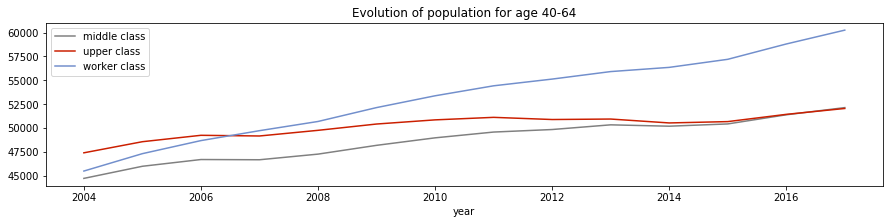

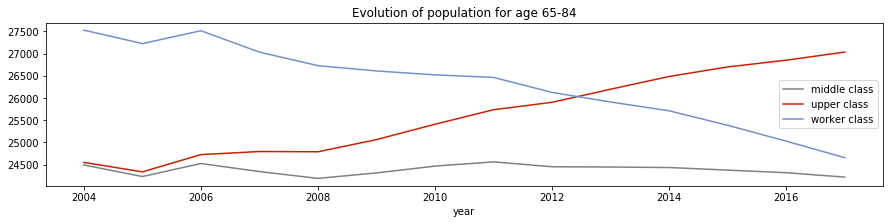

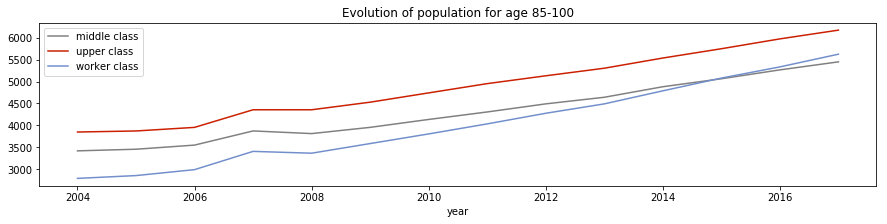

In [69]:
age_range_dfs_total[0].plot.line(colors=['#808080','#cb1f00','#728fcc'], 
                                 title="Evolution of population for age 0-24",figsize=(15,3))
plt.savefig("crisis_0-24.png")
age_range_dfs_total[1].plot.line(colors=['#808080','#cb1f00','#728fcc'], 
                                 title="Evolution of population for age 25-39",figsize=(15,3))
plt.savefig("crisis_25-39.png")
age_range_dfs_total[2].plot.line(colors=['#808080','#cb1f00','#728fcc'], 
                                 title="Evolution of population for age 40-64",figsize=(15,3))
plt.savefig("crisis_40-64.png")
age_range_dfs_total[3].plot.line(colors=['#808080','#cb1f00','#728fcc'], 
                                 title="Evolution of population for age 65-84",figsize=(15,3))
plt.savefig("crisis_65-84.png")
age_range_dfs_total[4].plot.line(colors=['#808080','#cb1f00','#728fcc'], 
                                 title="Evolution of population for age 85-100",figsize=(15,3))
plt.savefig("crisis_85-100.png")

### Conclusions

* Young people in working class districts run away from Madrid, likely they emigrate to other countries.
* It seems that families with children and teenagers moved mainly to working class districts.
* There is an increase of older population in all social classes but in working class districts in the range of 65-84, did they go back to their villages after going in rent or there was an increase of deaths?